In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as st
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

plt.style.use('default')

In [3]:
df = pd.read_csv('vgames2.csv')
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [5]:
# EDA, Data wrangling
df_clean = df.copy()

df_clean.drop('Unnamed: 0', axis=1, inplace=True)
df_clean.Genre.fillna('Misc')
df_clean.Publisher.fillna('Unknown')
df_clean.dropna(inplace=True)
df_clean.reset_index(drop=True, inplace=True)

# Year 이상치 수정 작업
df_clean.Year = df_clean.Year.astype(int)
year2000 = df_clean.Year[df_clean.Year < 23].index
year1990 = df_clean.Year[(df_clean.Year >= 23) & (df_clean.Year < 1900)].index
df_clean.Year = df_clean.Year.astype(str)
df_clean.Year[year2000] = '20' + df_clean.Year[year2000].str.zfill(2)
df_clean.Year[year1990] = '19' + df_clean.Year[year1990]
df_clean.Year = df_clean.Year.astype(int)
df_clean.Year = df_clean.Year.astype(object)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16241 non-null  object
 1   Platform     16241 non-null  object
 2   Year         16241 non-null  object
 3   Genre        16241 non-null  object
 4   Publisher    16241 non-null  object
 5   NA_Sales     16241 non-null  object
 6   EU_Sales     16241 non-null  object
 7   JP_Sales     16241 non-null  object
 8   Other_Sales  16241 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


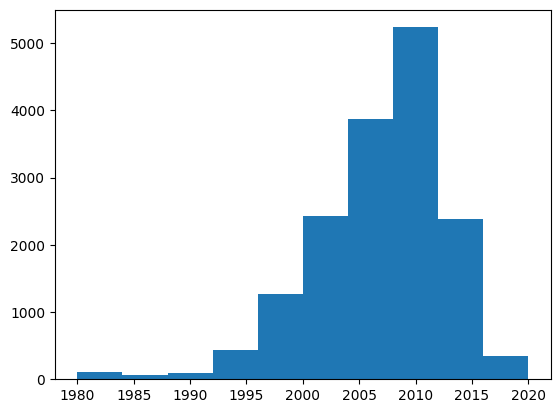

In [6]:
plt.hist(df_clean.Year);

In [7]:
df_clean.query("NA_Sales.str.contains(r'[a-zA-Z]')")

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
10,Ford Racing,PS,2001,Racing,Empire Interactive,480K,0.33M,0K,0.06
44,Resident Evil: Revelations 2,PS3,2015,Action,Capcom,60K,0.08,0.16,0.03
142,TOCA Race Driver 3,PC,2006,Racing,Codemasters,0K,0.02,0,0
439,Medal of Honor: Warfighter,X360,2012,Action,Electronic Arts,0.58M,0.47,0.01,0.1
450,F1 2010,PS3,2010,Racing,Codemasters,0.25M,0.76,0.08,0.27
...,...,...,...,...,...,...,...,...,...
15978,Midway Arcade Treasures,PS2,2003,Misc,Midway Games,720K,0.56,0,0.19
16056,NASCAR 06: Total Team Control,PS2,2005,Racing,Electronic Arts,0.53M,0.02,0,0.09
16127,Super Robot Taisen F Kanketsuhen,SAT,1998,Strategy,Banpresto,0M,0,0.55,0
16137,Mortal Kombat,PSV,2012,Fighting,Warner Bros. Interactive Entertainment,470K,0.18,0,0.12


In [8]:
def sales_change(df_, col):
  '''sales data change'''
  k_index = df_.query(col + ".str.contains(r'[K]')").index # 1000으로 나눠야함
  df_[col] = df_[col].str.replace(r'[a-zA-Z]', '', regex=True)
  df_[col] = df_[col].astype(float)
  df_k = (df_[col][k_index]).copy() # 메모리 공간에 대한 warning을 없애기 위해 작성한 코드, 별 소득이 없다.
  df_k = df_k.div(1000)
  df_[col][k_index] = df_k

In [9]:
# Sale 컬럼의 단위 통일
for i in range(5, 9):
  sales_change(df_clean, df_clean.columns[i])

/var/folders/5y/8vxkxcq10jbbp_61mxm4tcqw0000gn/T/ipykernel_65088/3448264505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[col][k_index] = df_k
/var/folders/5y/8vxkxcq10jbbp_61mxm4tcqw0000gn/T/ipykernel_65088/3448264505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[col][k_index] = df_k
/var/folders/5y/8vxkxcq10jbbp_61mxm4tcqw0000gn/T/ipykernel_65088/3448264505.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_[c

In [10]:
df_clean.describe()

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
count,16241.000000,16241.000000,16241.000000,16241.000000
mean,0.265195,0.147378,0.078283,0.048234
std,0.822431,0.508340,0.309272,0.189678
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.080000,0.020000,0.000000,0.010000
75%,0.240000,0.110000,0.040000,0.040000
max,41.490000,29.020000,10.220000,10.570000


(array([11530.,  2109.,   923.,   484.,   302.,   188.,   131.,   120.,
           73.,    66.]),
 array([0.   , 0.199, 0.398, 0.597, 0.796, 0.995, 1.194, 1.393, 1.592,
        1.791, 1.99 ]),
 <BarContainer object of 10 artists>)

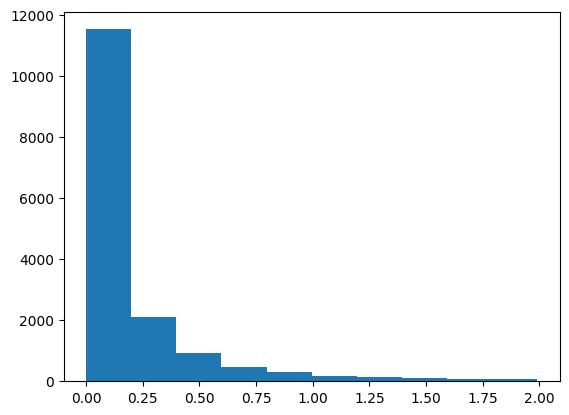

In [11]:
plt.hist(df_clean.NA_Sales[df_clean.NA_Sales < 2])

In [12]:
# Sales 데이터의 이상치 수정
i = 2
na_idx = df_clean[df_clean.NA_Sales > i].index
eu_idx = df_clean[df_clean.EU_Sales > i].index
jp_idx = df_clean[df_clean.JP_Sales > i].index
ot_idx = df_clean[df_clean.Other_Sales > i].index

In [13]:
df_clean.iloc[na_idx, 5] = 2
df_clean.iloc[eu_idx, 6] = 2
df_clean.iloc[jp_idx, 7] = 2
df_clean.iloc[ot_idx, 8] = 2

In [14]:
# object type 각각 Serise로 저장
name = df_clean['Name']
platform = df_clean['Platform']
genre = df_clean['Genre']
publisher = df_clean['Publisher']

In [15]:
# 인기 게임 분석 시 사용
df_year = df_clean.copy()
idx = df_year.Year[df_year.Year <= 2010].index
df_year.drop(idx, inplace=True)
df_math = df_year.copy()

In [16]:
df_year.shape

(3867, 9)

In [17]:
def change_to_int(df_, col):
  '''object value change to int'''
  for colunm in col:
    tmp = {string : i for i, string in enumerate(df_[colunm].unique())}
    df_[colunm] = df_[colunm].map(tmp)

In [18]:
change_to_int(df_math, ['Platform', 'Genre'])
df_math.drop(['Name', 'Publisher'], axis=1, inplace=True)

In [19]:
genre_count = df_year['Genre'].value_counts()
genre_count

Action          1208
Role-Playing     453
Adventure        385
Sports           384
Misc             361
Shooter          314
Racing           176
Fighting         156
Simulation       127
Platform         119
Strategy         114
Puzzle            70
Name: Genre, dtype: int64

In [20]:
country_genre = df_year.groupby(['Genre'])[['NA_Sales','EU_Sales','JP_Sales','Other_Sales']].sum()
country_genre

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,205.66,178.65,60.74,62.81
Adventure,14.34,13.83,11.72,4.39
Fighting,29.27,16.55,11.81,6.77
Misc,59.73,38.14,17.25,12.76
Platform,33.33,28.06,11.47,8.25
Puzzle,2.84,3.57,2.91,0.71
Racing,27.41,38.97,4.94,10.75
Role-Playing,65.78,51.67,66.29,18.45
Shooter,136.16,119.75,11.42,45.88


In [21]:
genre_len = np.arange(len(country_genre.index))

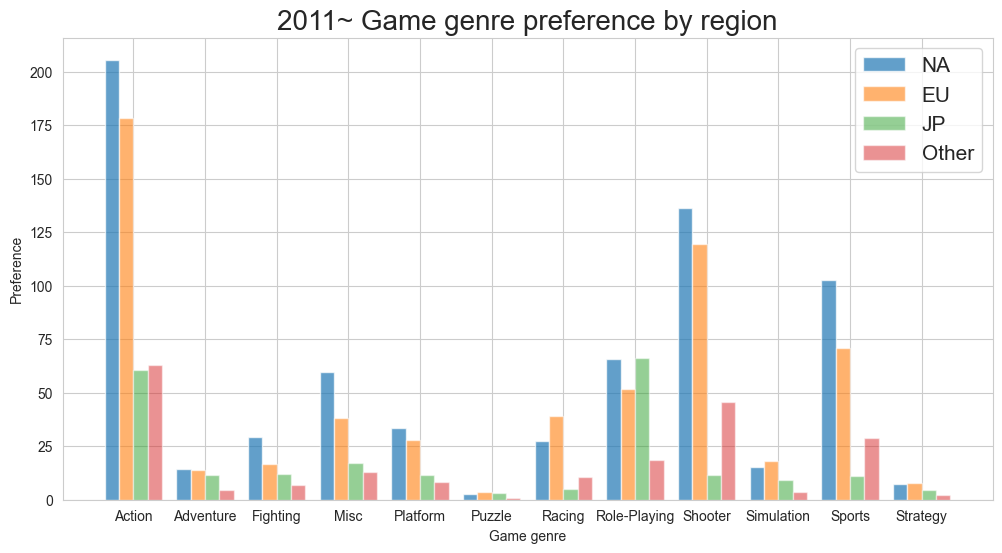

In [22]:
plt.figure(figsize=(12,6))
sns.set_style('whitegrid')
plt.bar(genre_len -.3, country_genre['NA_Sales'], width=.2, alpha=.7, label='NA')
plt.bar(genre_len -.1, country_genre['EU_Sales'], width=.2, alpha=.6, label='EU')
plt.bar(genre_len +.1, country_genre['JP_Sales'], width=.2, alpha=.5, label='JP')
plt.bar(genre_len +.3, country_genre['Other_Sales'], width=.2, alpha=.5, label='Other')
plt.title('2011~ Game genre preference by region', fontsize=20)
plt.ylabel('Preference')
plt.xlabel('Game genre')
plt.xticks(genre_len, genre_count.index.sort_values(), rotation=0)
plt.legend(fontsize=15)
plt.show()

In [23]:
# 지역마다 동일여부
# 귀무가설 : 지역 n = 지역 m
# 대립가설 : 지역 n != 지역 m

pvalue = {'NA_EU':0, 'NA_JP':0, 'NA_Other':0, 'EU_JP':0, 'EU_Other':0, 'JP_Other':0}
plist = []

for i in range(3):
    for j in range(i+1, 4):
        pv = st.f_oneway(country_genre.iloc[:,i],country_genre.iloc[:,j])[1]
        plist.append(pv)

for i,keys in enumerate(pvalue.keys()):
    pvalue[keys] = round(plist[i], 3)

pvalue

{'NA_EU': 0.686,
 'NA_JP': 0.046,
 'NA_Other': 0.037,
 'EU_JP': 0.077,
 'EU_Other': 0.061,
 'JP_Other': 0.86}

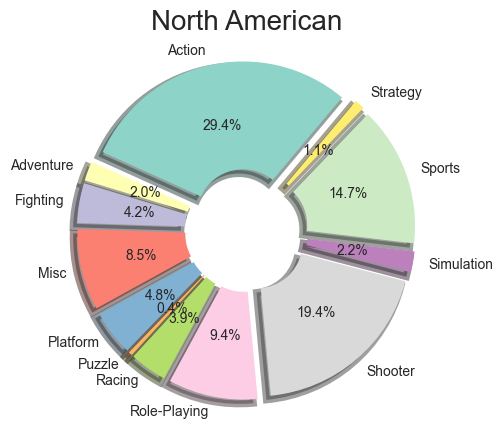

In [24]:
expl = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
cmap = plt.cm.Set3
inner_c = cmap(np.linspace(0,1,12))

plt.figure(figsize=(5,5))
plt.title('North American', fontsize=20)
plt.pie(country_genre['NA_Sales'],
        explode=expl,
        labels=country_genre.index,
        autopct='%1.1f%%',
        startangle=50,
        wedgeprops={'width':0.7, 'edgecolor':'None', 'linewidth':5},
        shadow=True,
        colors=inner_c)
plt.show()

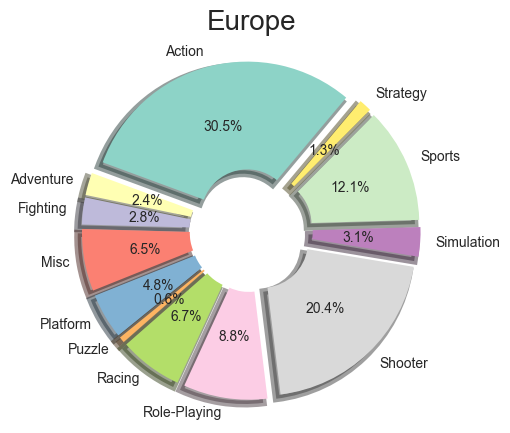

In [25]:
plt.figure(figsize=(5,5))
plt.title('Europe', fontsize=20)
plt.pie(country_genre['EU_Sales'],
        explode=expl,
        labels=country_genre.index,
        autopct='%1.1f%%',
        startangle=50,
        wedgeprops={'width':0.7, 'edgecolor':'None', 'linewidth':5},
        shadow=True,
        colors=inner_c)
plt.show()

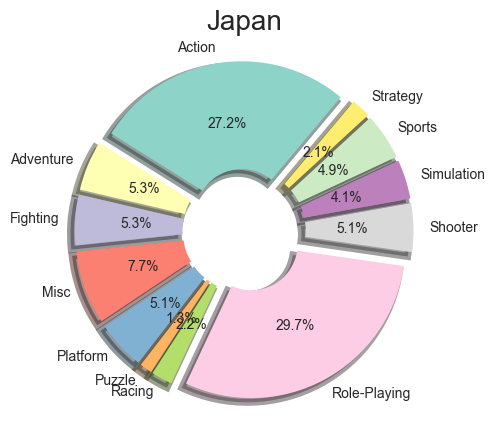

In [26]:
plt.figure(figsize=(5,5))
plt.title('Japan', fontsize=20)
plt.pie(country_genre['JP_Sales'],
        explode=expl,
        labels=country_genre.index,
        autopct='%1.1f%%',
        startangle=50,
        wedgeprops={'width':0.7, 'edgecolor':'None', 'linewidth':5},
        shadow=True,
        colors=inner_c)
plt.show()

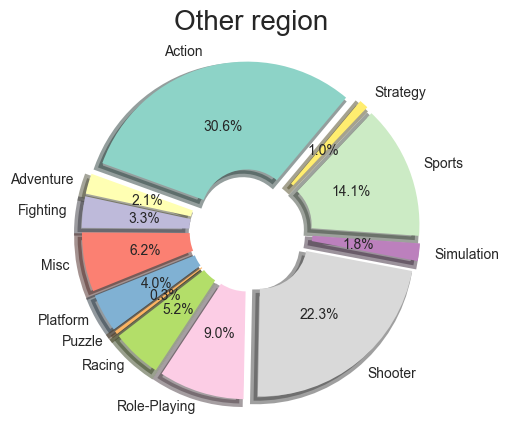

In [27]:
plt.figure(figsize=(5,5))
plt.title('Other region', fontsize=20)
plt.pie(country_genre['Other_Sales'],
        explode=expl,
        labels=country_genre.index,
        autopct='%1.1f%%',
        startangle=50,
        wedgeprops={'width':0.7, 'edgecolor':'None', 'linewidth':5},
        shadow=True,
        colors=inner_c)
plt.show()

In [28]:
Genre_Year = df_clean.groupby('Year', as_index=False)['Genre'].value_counts()
gy_max = Genre_Year[Genre_Year.groupby('Year')['count'].transform(max) == Genre_Year['count']]

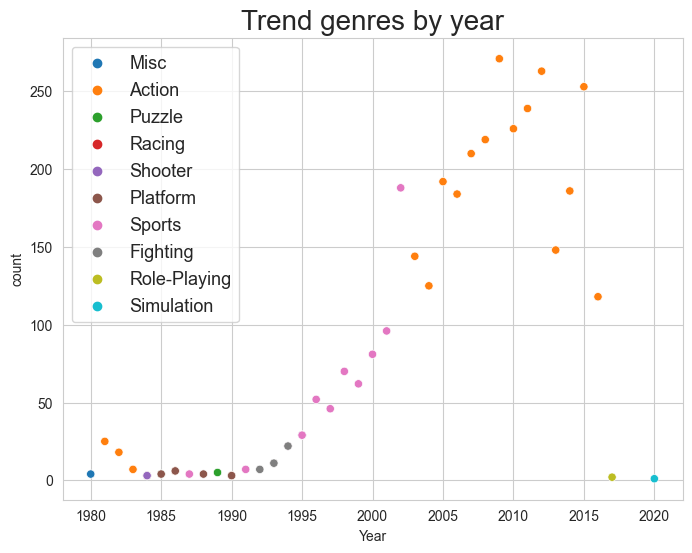

In [29]:
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
plt.title('Trend genres by year', fontsize=20)
sns.scatterplot(data=gy_max, x=gy_max['Year'], y=gy_max['count'], hue=gy_max['Genre'])
plt.legend(fontsize=13)
plt.show()

In [30]:
df_math.drop('Year', axis=True, inplace=True)
df_math

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
6,0,0,0.02,0.01,0.00,0.00
9,1,1,0.04,0.03,0.00,0.01
17,1,2,0.00,0.00,0.03,0.00
18,2,3,0.02,0.00,0.03,0.00
23,3,2,0.00,0.01,0.00,0.00
...,...,...,...,...,...,...
16224,4,9,0.00,0.03,0.00,0.00
16225,7,1,0.13,0.12,0.00,0.02
16231,1,5,0.07,0.08,0.00,0.03
16238,1,2,0.44,0.19,0.03,0.13


In [31]:
df_math.corr().style.background_gradient(cmap='summer')

,Platform,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Platform,1.000000,0.042218,-0.102650,-0.162624,0.064081,-0.152428
Genre,0.042218,1.000000,-0.069208,-0.051311,-0.039998,-0.052540
NA_Sales,-0.102650,-0.069208,1.000000,0.787432,0.221250,0.737040
EU_Sales,-0.162624,-0.051311,0.787432,1.000000,0.251321,0.870698
JP_Sales,0.064081,-0.039998,0.221250,0.251321,1.000000,0.212588
Other_Sales,-0.152428,-0.052540,0.737040,0.870698,0.212588,1.000000


In [32]:
# Scalering
robust = robust_scale(df_math)
standard = StandardScaler().fit_transform(df_math)

# pc1 = 0.62247864, pc2 = 0.28677306
pca = pca2 = PCA()
pca.fit(robust)
projected = pca.transform(robust)

# pc1 = 0.45440353, pc2 = 0.17728736, pc3 = 0.16607168
# pca2.fit(standard)
# projected2 = pca2.transform(standard)

In [33]:
elbow = {}

for i in range(1, 10):
  kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
  kmeans.fit(projected)
  elbow[i] = kmeans.inertia_

<AxesSubplot: >

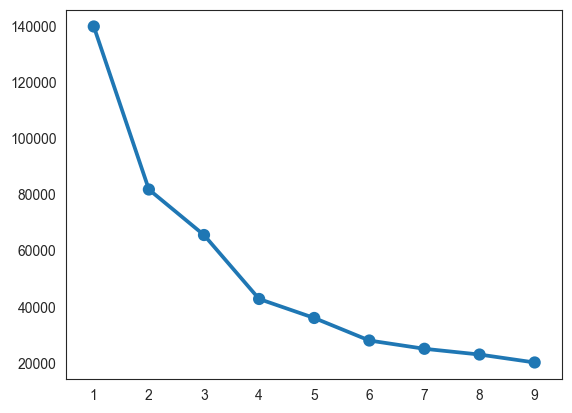

In [34]:
sns.set_style('white')
sns.pointplot(x=list(elbow.keys()), y=list(elbow.values())) # 엘보우메서드를 참조해서 3~5개의 클러스터로 진행할 예정

In [35]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=1)
kmeans.fit(projected)
labels = kmeans.labels_

df_cluster = df_year.assign(cluster=labels)
df_cluster['Total_Sales'] = df_cluster['NA_Sales'] + df_cluster['EU_Sales'] + df_cluster['JP_Sales'] + df_cluster['Other_Sales']
df_cluster

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,cluster,Total_Sales
6,JASF: Jane's Advanced Strike Fighters,PC,2011,Simulation,Deep Silver,0.02,0.01,0.00,0.00,0,0.03
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011,Action,THQ,0.04,0.03,0.00,0.01,0,0.08
17,Hajime no Ippo: The Fighting! (2014),PS3,2014,Sports,Namco Bandai Games,0.00,0.00,0.03,0.00,0,0.03
18,Grand Kingdom,PS4,2015,Role-Playing,Nippon Ichi Software,0.02,0.00,0.03,0.00,0,0.05
23,Don Bradman Cricket 14,X360,2014,Sports,Tru Blu Entertainment,0.00,0.01,0.00,0.00,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...
16224,Captain Morgane and the Golden Turtle,DS,2012,Adventure,Reef Entertainment,0.00,0.03,0.00,0.00,0,0.03
16225,LEGO The Hobbit,XOne,2014,Action,Warner Bros. Interactive Entertainment,0.13,0.12,0.00,0.02,0,0.27
16231,MindJack,PS3,2011,Shooter,Square Enix,0.07,0.08,0.00,0.03,0,0.18
16238,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0,0.79


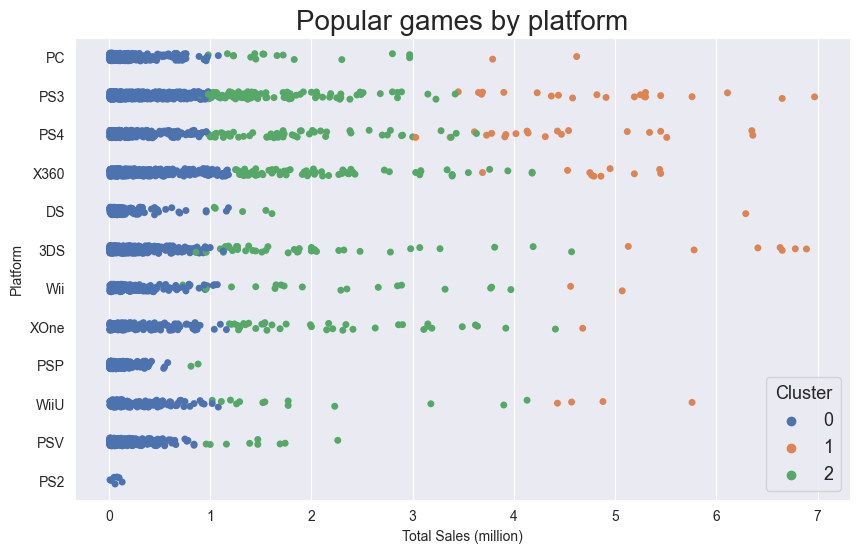

In [36]:
# 인기순 클러스터 2 -> 4 -> 3 -> 1 -> 0

plt.figure(figsize=(10,6))
sns.set_style('darkgrid')

sns.stripplot(data=df_cluster,
                x='Total_Sales',
                y='Platform',
                hue='cluster',
                palette='deep',
                jitter=True)
plt.title('Popular games by platform', fontsize=20)
plt.xlabel('Total Sales (million)')
plt.legend(title='Cluster', title_fontsize=13, fontsize=13)
plt.show()

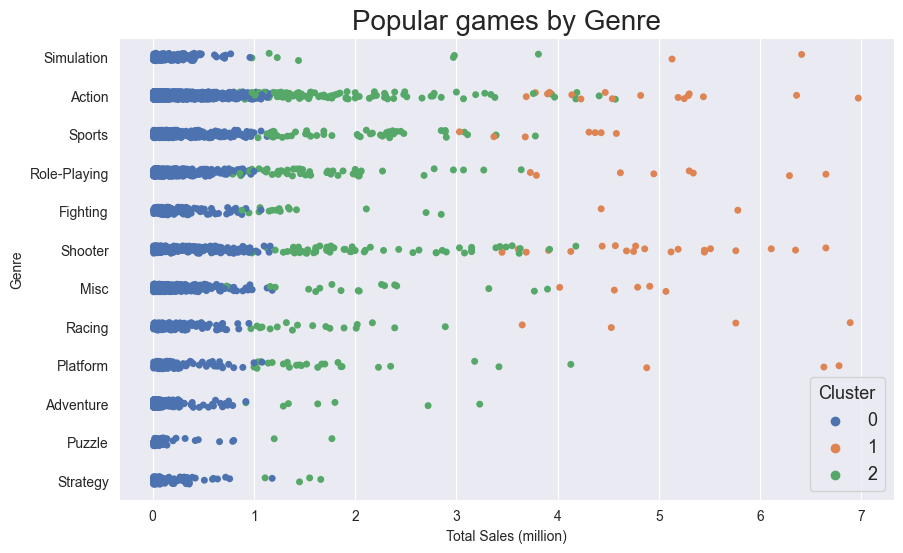

In [37]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.stripplot(data=df_cluster,
                x='Total_Sales',
                y='Genre',
                hue='cluster',
                palette='deep',
                jitter=True)
plt.title('Popular games by Genre', fontsize=20)
plt.xlabel('Total Sales (million)')
plt.legend(title='Cluster', title_fontsize=13, fontsize=13)
plt.show()

In [38]:
clt1 = df_cluster[df_cluster.cluster == 1]
clt1

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,cluster,Total_Sales
220,Just Dance 3,Wii,2011,Misc,Ubisoft,2.00,2.00,0.00,1.07,1,5.07
466,Call of Duty: Advanced Warfare,PS3,2014,Shooter,Activision,1.54,1.94,0.19,0.77,1,4.44
561,Far Cry 3,PS3,2012,Shooter,Ubisoft,0.88,1.75,0.10,0.72,1,3.45
1601,Assassin's Creed III,PS3,2012,Action,Ubisoft,2.00,2.00,0.16,1.14,1,5.30
1610,The Elder Scrolls V: Skyrim,PC,2011,Role-Playing,Bethesda Softworks,1.15,2.00,0.00,0.64,1,3.79
...,...,...,...,...,...,...,...,...,...,...,...
15337,Pokemon Black 2/Pokemon White 2,DS,2012,Role-Playing,Nintendo,2.00,1.86,2.00,0.43,1,6.29
15637,Call of Duty: Black Ops 3,XOne,2015,Shooter,Activision,2.00,2.00,0.01,0.67,1,4.68
15648,Assassin's Creed: Revelations,PS3,2011,Action,Ubisoft,1.41,2.00,0.10,0.72,1,4.23
15980,Assassin's Creed IV: Black Flag,PS3,2013,Action,Ubisoft,1.33,1.71,0.13,0.73,1,3.90


In [39]:
idx = clt1[clt1.Name.duplicated()].index
clt1_drop = clt1.drop(idx)

In [40]:
clt1_drop

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,cluster,Total_Sales
220,Just Dance 3,Wii,2011,Misc,Ubisoft,2.00,2.00,0.00,1.07,1,5.07
466,Call of Duty: Advanced Warfare,PS3,2014,Shooter,Activision,1.54,1.94,0.19,0.77,1,4.44
561,Far Cry 3,PS3,2012,Shooter,Ubisoft,0.88,1.75,0.10,0.72,1,3.45
1601,Assassin's Creed III,PS3,2012,Action,Ubisoft,2.00,2.00,0.16,1.14,1,5.30
1610,The Elder Scrolls V: Skyrim,PC,2011,Role-Playing,Bethesda Softworks,1.15,2.00,0.00,0.64,1,3.79
1973,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,2.00,2.00,0.36,2.00,1,6.36
2217,Far Cry 4,PS4,2014,Shooter,Ubisoft,1.12,2.00,0.10,0.69,1,3.91
2330,Batman: Arkham Knight,PS4,2015,Action,Warner Bros. Interactive Entertainment,1.49,1.58,0.10,0.61,1,3.78
2587,FIFA 16,PS4,2015,Sports,Electronic Arts,1.11,2.00,0.06,1.26,1,4.43
2671,FIFA 14,PS3,2013,Sports,Electronic Arts,0.78,2.00,0.07,1.73,1,4.58


In [41]:
clt1_genre_count = clt1_drop.Genre.value_counts()
clt1_genre_count

Shooter         15
Action          12
Role-Playing     6
Sports           6
Racing           4
Misc             3
Platform         3
Simulation       2
Fighting         1
Name: Genre, dtype: int64

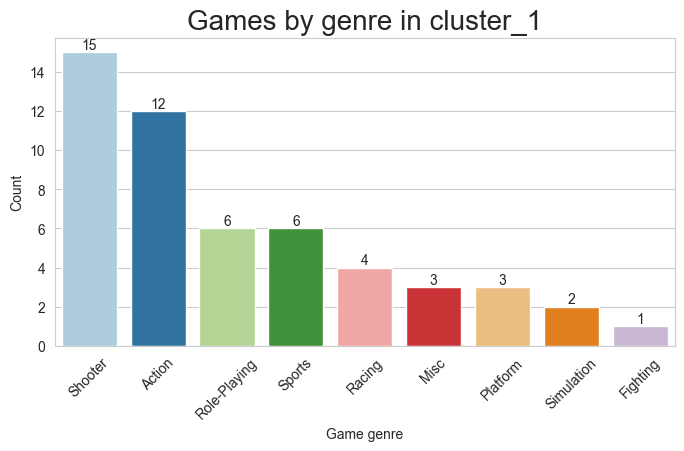

In [42]:
plt.figure(figsize=(8,4))
sns.set_style('whitegrid')
plt.title('Games by genre in cluster_1', fontsize=20)
sns.barplot(x=clt1_genre_count.index, y=clt1_genre_count, palette='Paired')
for i in range(len(clt1_genre_count)):
  plt.text(i, clt1_genre_count[i], str(clt1_genre_count[i]), va='bottom', ha='center')

plt.ylabel('Count')
plt.xlabel('Game genre')
plt.xticks(rotation=45)
plt.show()

In [45]:
roleplaying = df_cluster.query('Genre == "Role-Playing"')
sports = df_cluster.query('Genre == "Sports"')

In [59]:
# 귀무가설 : Role-Playing장르가 Sports장르보다 인기가 높거나 같다
# 대립가설 : Sports장르가 Role-Playing장르보다 인기가 높다.

pv = pg.ttest(roleplaying['Total_Sales'], sports['Total_Sales'], alternative='less')
print('가설검정 RPG_Sports\np-value =', pv['p-val'][0].round(3))

가설검정 RPG_Sports
p-value = 0.029


In [ ]:
clt1.Publisher.unique()

array(['Ubisoft', 'Activision', 'Bethesda Softworks',
       'Take-Two Interactive', 'Warner Bros. Interactive Entertainment',
       'Electronic Arts', 'Sony Computer Entertainment', 'Nintendo',
       'Microsoft Game Studios', 'Sony Computer Entertainment Europe',
       'Namco Bandai Games'], dtype=object)

In [ ]:
clt1.Year.mean()

2013.0294117647059